In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from utils.dataset import get_dataloaders 
from utils.metrics import evaluate_model     

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = r'Pets\Master Folder'
train_loader, val_loader, class_names = get_dataloaders(data_dir)
num_classes = len(class_names)

In [3]:
def get_best_model_name(log_file="best_models_log.txt"):
    best_model = None
    best_acc = 0.0
    with open(log_file, "r") as f:
        for line in f:
            name, acc = line.strip().split(",")
            acc = float(acc)
            if acc > best_acc:
                best_acc = acc
                best_model = name
    return best_model
best_model_name = get_best_model_name()
print(" Best model from previous training:", best_model_name)

 Best model from previous training: mobilenet


Loads a pre-trained model from torchvision.models.
Freezes all pretrained layers (no gradient updates).
Replaces the classifier head with a new one adapted to the current number of classes

In [4]:
def get_pretrained_model(name, num_classes):
    if name == 'resnet':
        model = models.resnet18(pretrained=True)
        # Freeze all layers
        for param in model.parameters():
            param.requires_grad = False
        # Replace the last fc layer
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == 'mobilenet':
        model = models.mobilenet_v2(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == 'vgg':
        model = models.vgg16(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif name == 'densenet':
        model = models.densenet121(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif name == 'inception':
        model = models.inception_v3(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError(f"Unknown model name: {name}")

    return model.to(device)

Only trains the new classifier head using Adam optimizer.
Uses learning rate scheduling to reduce learning rate after 5 epochs, helping convergence.

In [5]:
model = get_pretrained_model(best_model_name, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

c:\Users\janaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\janaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\janaa/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:27<00:00, 518kB/s]


Trains the modified classifier head for 10 epochs.
Computes loss and backpropagates only for unfrozen parameters.
Evaluates model performance each epoch using classification report and confusion matrix.
Saves the best-performing model.

In [6]:
epochs = 10
best_acc = 0.0
train_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"\nEpoch [{epoch+1}/{epochs}] - Training Loss: {avg_loss:.4f}")

    # Evaluate on validation set
    report, accuracy, matrix = evaluate_model(model, val_loader, device, class_names)
    val_accuracies.append(accuracy)

    print("\nValidation Classification Report:\n", report)
    print("\nConfusion Matrix:\n", matrix)

    if accuracy > best_acc:
        best_acc = accuracy
        torch.save(model.state_dict(), f'transfer_best_model_{best_model_name}.pth')
        print(f"New best transfer model saved (Accuracy: {best_acc:.4f})")

    scheduler.step()


Epoch [1/10] - Training Loss: 1.3092

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.2917    0.7778    0.4242         9
       Other     0.0000    0.0000    0.0000         6
         Sad     1.0000    0.1000    0.1818        10
       happy     0.6250    0.4545    0.5263        11

    accuracy                         0.3611        36
   macro avg     0.4792    0.3331    0.2831        36
weighted avg     0.5417    0.3611    0.3174        36


Confusion Matrix:
 [[7 1 0 1]
 [5 0 0 1]
 [7 1 1 1]
 [5 1 0 5]]
New best transfer model saved (Accuracy: 0.3611)

Epoch [2/10] - Training Loss: 1.1079

Validation Classification Report:
               precision    recall  f1-score   support

       Angry     0.5455    0.6667    0.6000         9
       Other     0.3333    0.1667    0.2222         6
         Sad     0.4667    0.7000    0.5600        10
       happy     0.8571    0.5455    0.6667        11

    accuracy                   

In [7]:
def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

In [8]:
def plot_training_curves(train_losses, val_accuracies, model_name):
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, marker='o', color='blue', label='Training Loss')
    plt.title(f"{model_name.upper()} - Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_accuracies, marker='x', color='green', label='Validation Accuracy')
    plt.title(f"{model_name.upper()} - Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()



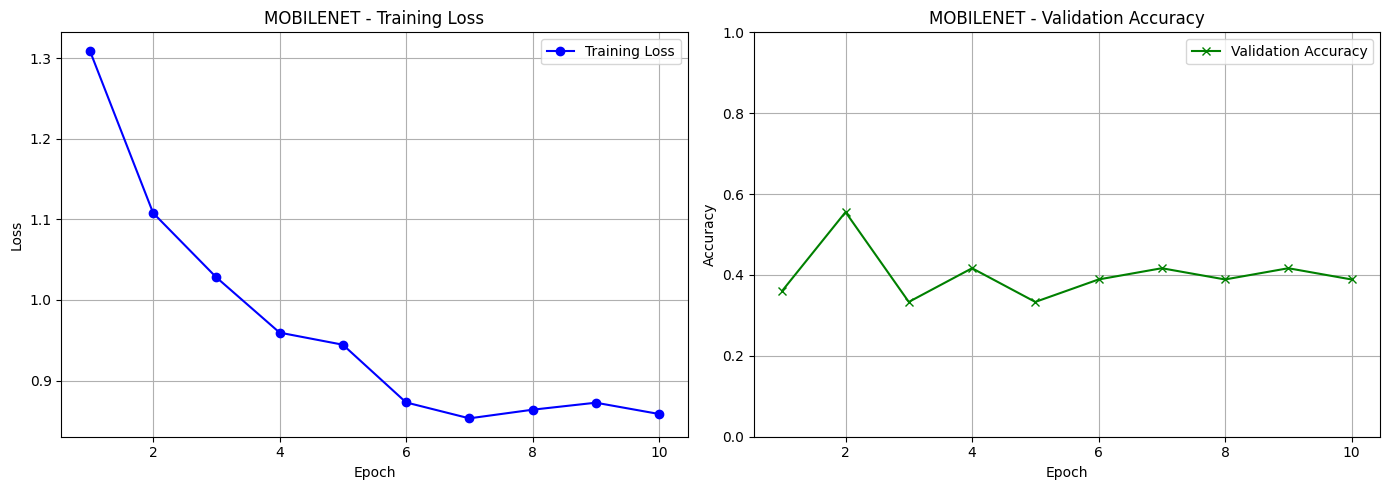

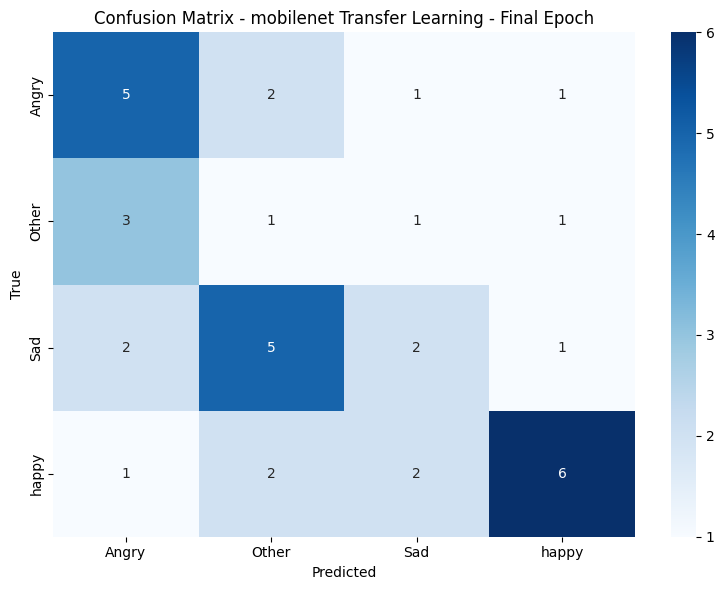


Transfer learning complete. Best validation accuracy: 0.5556



In [9]:
# Plot final results
plot_training_curves(train_losses, val_accuracies, best_model_name)
plot_confusion_matrix(matrix, class_names, f"{best_model_name} Transfer Learning - Final Epoch")

print(f"\nTransfer learning complete. Best validation accuracy: {best_acc:.4f}\n")